In [1]:
import torch
from torch import nn

from copy import deepcopy

import matplotlib.pyplot as plt

from IPython.display import display as d

# Forward State

In [2]:
from typing import List, Optional
from collections import namedtuple

In [3]:
_sfs = namedtuple("SFS", ["sequences", "mask"])


class SingleForwardState(_sfs):
    sequences: torch.Tensor
    mask: Optional[torch.Tensor] = None

    def __new__(
        cls, 
        sequences: Optional[torch.Tensor],
        mask: Optional[torch.Tensor] = None
    ): 
        return super().__new__(
            cls,
            sequences=sequences,
            mask=mask
        )

# Transformer

In [4]:
def clone_modules(module: nn.Module, N: int = 1):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [5]:
class SubLayer(nn.Module):
    """ Residual connection followed by a layer norm """
    def __init__(self, d_model: int, dropout: float = 0.5):
        super().__init__()

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, sub_layer: nn.Module) -> torch.Tensor:
        return x + self.dropout(sub_layer(self.layer_norm(x)))

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, attention: nn.Module, feed_forward: nn.Module, residual_dropout: float = 0.3):
        super(EncoderLayer, self).__init__()

        self.attn_layer = attention # z = x + dropout(attention(norm(x)))
        self.ff_layer = feed_forward # y = z + dropout(ff(norm(z)))

        self.d_model = self.attn_layer.d_model

        assert self.d_model == self.ff_layer.d_model, \
            f"The size <{self.d_model}> of attention layer must be the same as size <{self.ff_layer.d_model}> of feed forward layer"

        self.sub_layers = nn.ModuleDict(
            dict(
                zip(
                    ["attention", "feed_forward"],
                    clone_modules(SubLayer(self.d_model, residual_dropout), 2)
                )
            )
        )

    def forward(self, state: SingleForwardState) -> SingleForwardState:
        # mask = state.mask.unsqueeze(dim=1).unsqueeze(dim=-1)
        context = state.sequences
        mask = state.mask

        context = self.sub_layers["attention"](
            context, 
            lambda context: self.attn_layer(context, context, context, mask)
        )

        x = self.sub_layers["feed_forward"](context, self.ff_layer)

        return SingleForwardState(
            sequences=x,
            mask=state.mask
        )

In [7]:

class DecoderLayer(nn.Module):
    def __init__(self, src_attention: nn.Module, tgt_attention: nn.Module, feed_forward: nn.Module, residual_dropout: float = 0.3):
        super(DecoderLayer, self).__init__()

        self.tgt_attn_layer = tgt_attention
        self.src_attn_layer = src_attention
        self.ff_layer = feed_forward

        self.d_model = self.src_attn_layer.d_model

        assert self.d_model == self.ff_layer.d_model, \
            f"The size <{self.d_model}> of attention layer must be the same as size <{self.ff_layer.d_model}> of feed forward layer"

        self.sub_layers = nn.ModuleDict(
            dict(
                zip(
                    ["attention", "src_attention", "feed_forward"],
                    clone_modules(SubLayer(self.d_model, residual_dropout), 3)
                )
            )
        )

    def forward(self, x: SingleForwardState, memory: SingleForwardState) -> SingleForwardState:

        tgt_mask = x.mask
        x = x.sequences

        src_mask = memory.mask
        memory = memory.sequences

        x = self.sub_layers["attention"](x, lambda x: self.tgt_attn_layer(x, x, x, tgt_mask))

        x = self.sub_layers["src_attention"](x, lambda x: self.src_attn_layer(x, memory, memory, src_mask))

        x = self.sub_layers["feed_forward"](x, self.ff_layer)

        return SingleForwardState(
            sequences=x,
            mask=tgt_mask
        )

In [43]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature: float, dropout: float = 0.1):
        super().__init__()

        self.temperature = torch.sqrt(torch.tensor(temperature))
        self.softmax_dropout = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.Dropout(dropout)
        )

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # (B, h, L, d)

        attn = torch.matmul(query, key) / self.temperature

        # (B, h, L, L) or (B, h, L, d_proj)

        if mask is not None:
            attn = attn.masked_fill(~mask, -1.0e9)
        
        attn = self.softmax_dropout(attn)

        # print(f"P: {attn.size()}")

        x = torch.matmul(attn, value)

        # (B, h, L, d_v)

        return x, attn

In [44]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 1, dropout: float = 0.1, seq_len: int = None, d_proj: int = None):
        super(MultiHeadAttention, self).__init__()

        self.linears = clone_modules(nn.Linear(d_model, d_model * n_heads), 3)

        self.seq_len = seq_len

        if self.seq_len is not None:
            d_proj = self.seq_len // 4 if d_proj is None else d_proj

            self.E_projection = nn.Linear(self.seq_len, d_proj)
            self.F_projection = nn.Linear(self.seq_len, d_proj)

        self.attention = ScaledDotProductAttention(d_model, dropout)

        self.out_block = nn.Linear(d_model * n_heads, d_model)

        self.d_model = d_model
        self.n_heads = n_heads
        

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # (B, L, d)
        n_batches = query.size(0)

        query, key, value = [
            layer(x).view(n_batches, -1, self.n_heads, self.d_model).transpose(1, 2) \
                for layer, x in zip(self.linears, (query, key, value))
        ]

        # q ~ (B, h, L, d_qk) # h = num_heads
        # k ~ (B, h, L, d_qk) # h = num_heads
        # v ~ (B, h, L, d_v) # h = num_heads
        # d_v == d_qk by default

        if self.seq_len is not None:
            key = self.E_projection(key.transpose(-2, -1))
            value = self.F_projection(value.transpose(-2, -1)).transpose(-2, -1)
            # q ~ (B, h, L, d_qk)
            # k ~ (B, h, d_qk, d_proj) => P ~ (B, h, L, d_proj)
            # v ~ (B, h, d_proj, d_v) => matmul(P, v) ~ (B, h, L, d_v)
        else:
            key = key.transpose(-2, -1)

        context, _ = self.attention(query, key, value, mask)

        # (B, h, L, d_v)

        # .contiguous() -> makes a copy of the tensor with its own layout ~ for view
        context = context.transpose(1, 2).contiguous().view(n_batches, -1, self.d_model * self.n_heads)

        # (B, L, d_v * h)

        context = self.out_block(context)

        # (B, L, d)

        return context

In [45]:
ACTIVATION_TYPE_MAPPING = {
    "tanh": nn.Tanh,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
    "none": nn.Identity
}

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int = None, activation_type: str = "relu"):
        super(PositionwiseFeedForward, self).__init__()

        d_ff = d_ff if d_ff is not None else d_model * 2

        if activation_type in ACTIVATION_TYPE_MAPPING.keys():
            self.act = ACTIVATION_TYPE_MAPPING[activation_type]
        else: 
            NotImplementedError(f"activation_type must be in <{list(ACTIVATION_TYPE_MAPPING.keys())}>")

        self.position_wise_ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            self.act(),
            nn.Linear(d_ff, d_model)
        )

        self.d_model = d_model
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # z = ReLU(x @ W1 + b1) @ W2 + b2
        return self.position_wise_ff(x)

In [11]:
# embedding -> positional encoding -> encoder -> decoder

In [12]:
class Encoder(nn.Module):
    def __init__(self, encoder_layer: nn.Module, n_layers: int = 1):
        super(Encoder, self).__init__()

        self.layers = clone_modules(encoder_layer, n_layers)

        self.layer_norm = nn.LayerNorm(encoder_layer.d_model)


    def forward(self, x: SingleForwardState) -> SingleForwardState:

        for layer in self.layers:
            x = layer(x)
            
        return SingleForwardState(
            sequences=self.layer_norm(x.sequences),
            mask=x.mask
        )

In [13]:
class Decoder(nn.Module):
    def __init__(self, decoder_layer: nn.Module, n_layers: int = 1):
        super(Decoder, self).__init__()

        self.layers = clone_modules(decoder_layer, n_layers)

        self.layer_norm = nn.LayerNorm(decoder_layer.d_model)


    def forward(self, x: SingleForwardState, memory: SingleForwardState) -> SingleForwardState:

        for layer in self.layers:
            x = layer(x, memory)
            
        return SingleForwardState(
            sequences=self.layer_norm(x.sequences),
            mask=x.mask
        )

In [14]:
class BaseTransformer(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module = None):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder


    def forward(self, src: SingleForwardState, tgt: SingleForwardState = None) -> SingleForwardState:
        
        state = self.encoder(src)

        if self.decoder is not None:
            assert tgt is None, "tgt is None"

            state = self.decoder(tgt, state)

        return state

In [15]:
class Generator(nn.Module):
    def __init__(self, d_model: int, out_size: int):
        super().__init__()

        self.projection = nn.Sequential(
            nn.Linear(d_model, out_size),
            nn.LogSoftmax(dim=-1)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x)

In [16]:
class SequentialModel(nn.Module):
    def __init__(
            self, 
            layers: List[nn.Module],
            embedding_dim: int = 32
        ) -> None:
        super(SequentialModel, self).__init__()

        self.layers = nn.Sequential(*layers)


    def forward(self, inputs: SingleForwardState) -> torch.Tensor:
        
        state = self.layers(inputs)

        return state

In [61]:
EMB_DIM = 32

In [62]:
model = BaseTransformer(
    Encoder(
        encoder_layer=EncoderLayer(
            attention=MultiHeadAttention(d_model=EMB_DIM, n_heads=2, seq_len=128, d_proj=EMB_DIM),
            # attention=MultiHeadAttention(d_model=EMB_DIM, n_heads=2),
            feed_forward=PositionwiseFeedForward(EMB_DIM, activation_type="relu")
        ),
        n_layers=1
    )
)

In [63]:
d(sum([params.numel() for params in model.parameters()]))

21056

In [49]:
from PIL import Image
import numpy as np

In [66]:
sample_image = torch.from_numpy(np.array(Image.open("sample_jpg_image.jpg")).mean(axis=-1)[np.newaxis, ...])

In [51]:
d(sample_image.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

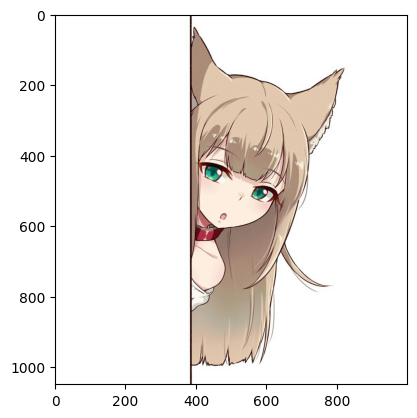

In [52]:
plt.imshow(sample_image)

In [92]:
from torchvision.transforms import v2 as T

In [94]:
pre_sample_image = T.Compose([T.RandomResizedCrop(size=(128, 32)), T.Normalize(mean=[0.0], std=[1.0])])(sample_image) / 255.0

In [95]:
pre_sample_image = pre_sample_image.type(torch.float32)

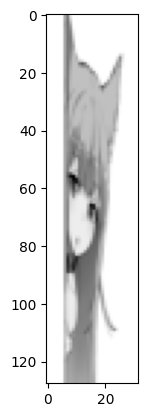

In [96]:
plt.imshow(pre_sample_image[0], cmap="gray")

In [97]:
sample = SingleForwardState(pre_sample_image)

In [98]:
d(pre_sample_image)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

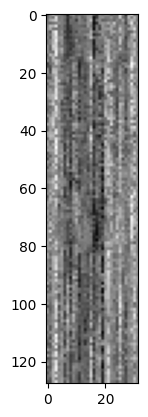

In [99]:
plt.imshow(model(sample).sequences[0].detach(), cmap="gray")

In [91]:
%timeit -n 1000 model(sample)

1.55 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [72]:
model_output = model(SingleForwardState(sample))

In [73]:
d(model_output)

tensor([[[-0.1540,  0.0988,  1.0209,  ..., -1.4779, -0.2646,  1.8035],
         [-1.1328, -0.7450,  0.6116,  ..., -1.0299,  0.7786,  1.9771],
         [-0.0577,  0.0534,  0.7577,  ..., -1.5262,  0.7232,  1.6251],
         ...,
         [-0.4153, -0.2539,  0.8670,  ..., -1.6799,  0.8332,  1.4802],
         [ 0.0700,  0.1127, -0.2182,  ..., -2.4002,  0.1127,  1.2435],
         [-0.5229, -0.2194,  1.1126,  ..., -2.0434, -0.2052,  1.1140]],

        [[-0.3884, -0.2303,  1.0249,  ..., -1.5751,  0.7953,  1.2303],
         [-0.5572, -0.3588,  1.1358,  ..., -2.1281,  1.1864,  0.5141],
         [-1.2181, -0.7078,  0.6844,  ..., -1.0795,  0.8290,  1.8595],
         ...,
         [ 0.0374, -1.3876, -0.6075,  ..., -0.5021,  1.5006,  0.7516],
         [-0.2472, -0.0266, -0.3207,  ..., -2.2248,  1.2504,  0.8718],
         [-0.3548, -0.0982,  0.7266,  ..., -1.6906,  0.7598,  1.4720]],

        [[-0.2628,  0.0440, -0.0519,  ..., -1.4741,  1.1639,  1.8134],
         [-0.3451, -0.3300, -0.8540,  ..., -0